<a href="https://colab.research.google.com/github/young9496/Machine-Learning-Test/blob/main/IskandarMove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Loading

In [1]:
import pandas as pd
shipping_url = "https://raw.githubusercontent.com/young9496/Machine-Learning-Test/main/exam%20dataset%201.csv"
payment_url = "https://raw.githubusercontent.com/young9496/Machine-Learning-Test/main/exam%20dataset.csv"
shipping = pd.read_csv(shipping_url)
payment = pd.read_csv(payment_url)
print("Shipping dataset shape:", shipping.shape)
print("Payment dataset shape:", payment.shape)
print("\nShipping Data Head")
print(shipping.head())
print("\nPayment Data Head")
print(payment.head())

Shipping dataset shape: (200, 8)
Payment dataset shape: (200, 7)

Shipping Data Head
   Shipping_ID Customer_ID Shipping_Content      SH_Domain SER_TYPE  \
0          690         230       Healthcare       Domestic  Regular   
1          933        3189       Healthcare  International  Express   
2          261        2216          Luggage       Domestic  Express   
3          445        1904  Home Furnishing       Domestic  Express   
4          722        7342      Electronics  International      NaN   

   SH_WEIGHT  SH_CHARGES  Duration (Days)  
0      553.0      1210.0             21.0  
1      810.0      1114.0             10.0  
2      994.0      1020.0              4.0  
3      598.0      1351.0             25.0  
4      412.0       566.0             17.0  

Payment Data Head
                             Payment_ID  Customer_ID  Shipping_ID  AMOUNT  \
0  313cd69e-66f3-11ea-9879-7077813058ce        230.0          690   49302   
1  313dc140-66f3-11ea-a952-7077813058ce       3189.

Data Inspection

In [2]:
print("\n--- Shipping Info ---")
shipping.info()
print("\nMissing in Shipping:")
print(shipping.isnull().sum())
print("\n--- Payment Info ---")
payment.info()
print("\nMissing in Payment:")
print(payment.isnull().sum())
print("\nDuplicate rows in Shipping:", shipping.duplicated().sum())
print("Duplicate rows in Payment:", payment.duplicated().sum())


--- Shipping Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Shipping_ID       200 non-null    int64  
 1   Customer_ID       198 non-null    object 
 2   Shipping_Content  198 non-null    object 
 3   SH_Domain         195 non-null    object 
 4   SER_TYPE          197 non-null    object 
 5   SH_WEIGHT         199 non-null    float64
 6   SH_CHARGES        199 non-null    float64
 7   Duration (Days)   199 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 12.6+ KB

Missing in Shipping:
Shipping_ID         0
Customer_ID         2
Shipping_Content    2
SH_Domain           5
SER_TYPE            3
SH_WEIGHT           1
SH_CHARGES          1
Duration (Days)     1
dtype: int64

--- Payment Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 # 

Data cleaning

In [3]:
shipping.columns = [c.strip().replace(" ", "_").replace("(", "").replace(")", "") for c in shipping.columns]
payment.columns = [c.strip().replace(" ", "_").replace("(", "").replace(")", "") for c in payment.columns]
print("Shipping columns:", shipping.columns.tolist())
print("Payment columns:", payment.columns.tolist())

Shipping columns: ['Shipping_ID', 'Customer_ID', 'Shipping_Content', 'SH_Domain', 'SER_TYPE', 'SH_WEIGHT', 'SH_CHARGES', 'Duration_Days']
Payment columns: ['Payment_ID', 'Customer_ID', 'Shipping_ID', 'AMOUNT', 'Payment_Status', 'Payment_Mode', 'Payment_Date']


In [5]:
import numpy as np
payment["Payment_Date"] = pd.to_datetime(payment["Payment_Date"], errors="coerce")
for df in [shipping, payment]:
    for col in ["Customer_ID", "Shipping_ID"]:
        if col in df.columns:
            df[col] = df[col].astype(str).replace("nan", np.nan)

for col in ["SH_WEIGHT", "SH_CHARGES", "Duration_Days"]:
    if col in shipping.columns:
        shipping[col] = shipping[col].fillna(shipping[col].median())

if "AMOUNT" in payment.columns:
    payment["AMOUNT"] = pd.to_numeric(payment["AMOUNT"], errors="coerce")
    payment["AMOUNT"] = payment["AMOUNT"].fillna(payment["AMOUNT"].median())

for col in ["SH_Domain", "SER_TYPE", "Shipping_Content"]:
    if col in shipping.columns:
        shipping[col] = shipping[col].fillna(shipping[col].mode()[0])

if "Payment_Status" in payment.columns:
    payment["Payment_Status"] = payment["Payment_Status"].fillna(payment["Payment_Status"].mode()[0])

if "Payment_ID" in payment.columns:
    missing_mask = payment["Payment_ID"].isnull()
    payment.loc[missing_mask, "Payment_ID"] = ["missing_pid_" + str(i) for i in range(missing_mask.sum())]

Merge Datasets

In [6]:
merged = shipping.merge(payment, on="Shipping_ID", how="left", suffixes=("_ship", "_pay"))
print("Merged shape:", merged.shape)
print(merged.head())

Merged shape: (200, 14)
  Shipping_ID Customer_ID_ship Shipping_Content      SH_Domain SER_TYPE  \
0         690              230       Healthcare       Domestic  Regular   
1         933             3189       Healthcare  International  Express   
2         261             2216          Luggage       Domestic  Express   
3         445             1904  Home Furnishing       Domestic  Express   
4         722             7342      Electronics  International  Express   

   SH_WEIGHT  SH_CHARGES  Duration_Days                            Payment_ID  \
0      553.0      1210.0           21.0  313cd69e-66f3-11ea-9879-7077813058ce   
1      810.0      1114.0           10.0  313dc140-66f3-11ea-a952-7077813058ce   
2      994.0      1020.0            4.0  313eab1e-66f3-11ea-81af-7077813058ce   
3      598.0      1351.0           25.0  313f474a-66f3-11ea-a78b-7077813058ce   
4      412.0       566.0           17.0  3140589a-66f3-11ea-a057-7077813058ce   

  Customer_ID_pay  AMOUNT Payment_Stat

Outlier Capping

In [7]:
def cap_outliers(series):
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    return series.clip(lower, upper)

for col in ["SH_WEIGHT", "SH_CHARGES", "AMOUNT"]:
    if col in merged.columns:
        merged[col] = cap_outliers(merged[col])

Feature Engineering

In [8]:
merged["cost_per_kg"] = merged.apply(lambda r: r["SH_CHARGES"]/r["SH_WEIGHT"] if r["SH_WEIGHT"] > 0 else 0, axis=1)
p75 = merged["SH_WEIGHT"].quantile(0.75)
merged["is_heavy"] = (merged["SH_WEIGHT"] > p75).astype(int)
med_dur = merged["Duration_Days"].median()
merged["fast_delivery"] = (merged["Duration_Days"] <= med_dur).astype(int)
merged["AMOUNT_log"] = np.log1p(merged["AMOUNT"])

Encode Categorical Variable

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
merged["Payment_Status_lbl"] = le.fit_transform(merged["Payment_Status"].astype(str))
merged = pd.get_dummies(merged, columns=["SER_TYPE", "SH_Domain"], prefix=["SER", "Domain"])

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ["SH_WEIGHT", "SH_CHARGES", "AMOUNT", "cost_per_kg"]
merged[[col + "_scaled" for col in scale_cols]] = scaler.fit_transform(merged[scale_cols])

EDA

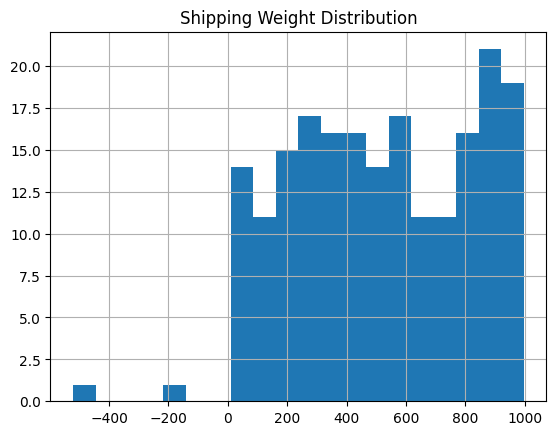

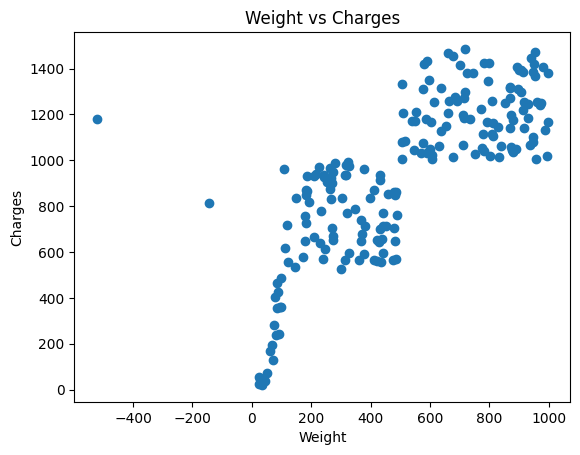

In [11]:
import matplotlib.pyplot as plt
merged["SH_WEIGHT"].hist(bins=20)
plt.title("Shipping Weight Distribution")
plt.show()
plt.scatter(merged["SH_WEIGHT"], merged["SH_CHARGES"])
plt.xlabel("Weight")
plt.ylabel("Charges")
plt.title("Weight vs Charges")
plt.show()

Time-based Analysis (to analyze the pattern)

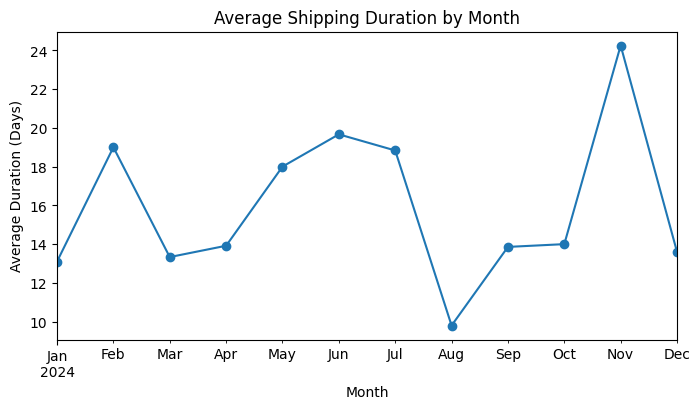

In [13]:
merged["Payment_Date"] = pd.to_datetime(merged["Payment_Date"], errors="coerce")
merged["Month"] = merged["Payment_Date"].dt.to_period("M")
monthly_duration = merged.groupby("Month")["Duration_Days"].mean()
monthly_duration.plot(kind="line", marker="o", figsize=(8,4))
plt.title("Average Shipping Duration by Month")
plt.ylabel("Average Duration (Days)")
plt.xlabel("Month")
plt.show()